In [1]:
from io import StringIO
from tqdm.notebook import tqdm_notebook as tqdm

import re
import nltk
import numpy as np
import pandas as pd
import requests
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
## checking if pytorch can use the gpu

# print(torch.cuda.current_device())
# print(torch.cuda.device(0))
# print(torch.cuda.get_device_name(0))
# print(torch.cuda.is_available())

# Constructing classes
In this section, we build classes which are later used to load and clean data. We moved this to the top of the notebook to declutter the following section and to make it easier for you to follow our workflow.

## Data-loading class
It has three metods: <br>
<ul>
    <li><b>__init__(url):</b> Class constructor, takes an URL to GDrive;</li>
    <li><b>load_csv():</b> Downloads a .csv from the GDrive link and returns it as pandas dataframe;</li>
    <li><b>load_txt():</b> Downloads a .txt file from the GDrive link and returns it as a string.</li>
</ul>

In [3]:
# class to load data
# following this stackoverflow post to download directly from Google Drive:
# https://stackoverflow.com/a/56611995

class DataLoader:
    def __init__(self, gdrive_url):
        """
        Class constructor
        Args:
            gdrive_url (str): URL to share Google Drive docs
        """
        self.path = gdrive_url   
    def load_csv(self):
        """
        Returns DataFrame containing data from csv
        Args:
            None
        """
        file_id = self.path.split('/')[-2]
        dwn_url='https://drive.google.com/uc?export=download&id=' + file_id
        url = requests.get(dwn_url).content
        csv_raw = StringIO(url.decode('utf-8'))
        df_ta = pd.read_csv(csv_raw)
        return(df_ta)
    
    def load_txt(self):
        """
        Returns String containing data from txt
        Args:
            None
        """
        file_id = self.path.split('/')[-2]
        dwn_url='https://drive.google.com/uc?export=download&id=' + file_id
        #print(dwn_url)
        url = requests.get(dwn_url).content
        scifi = StringIO(url.decode('utf-8')).getvalue()
        return(scifi)

#txt = DataLoader("https://drive.google.com/file/d/10ehW4jZND3QA29v9aNboYUett5-swuNe/view?usp=sharing").load_txt()

## Data-cleaner class
As suggested in McMahan (Natural Language Processing with PyTorch), we have proceeded by lower-casing each sentence, by removing the punctuation and the non alphabetic characters, also the stopwords have been stripped away from the text. <br>
The strings get lowercased in order to avoid seeing the words at the beginning of the phrases as different words. <br>
Whitespaces are used to tokenize the strings.<br>
This class has three methods and no constructor except from the default one: <br>
<ul>
    <li><b>remove_nonalpha_chars:</b> Takes as input a pandas dataframe and the name of a column, proceeds to remove all non alpha-chars from said column. Returns the cleaned dataframe;</li>
    <li><b>lower_casing():</b> Takes a pandas dataframe and the name of the column to operate on, all the uppercase chars become lowercase. Returns the lowercased dataframe;</li>
    <li><b>remove_stopwords():</b> Removes all the stopwords from the column of a dataframe, both fields of the function. It returns the cleaned dataframe.</li>
</ul>

In [46]:
# Stopword removal inspired by this stackoverlow answer
# https://stackoverflow.com/a/43407993/7505264
from nltk.corpus import stopwords
stop = stopwords.words('english')
tqdm.pandas()

class DataCleaner:
    def remove_nonalpha_chars(self, df, column):
        """
        Returns a processed DataFrame, does not change original
        Removes non-alpha characters
        Args:
            df (DataFrame): DataFrame containing the corpus
            column (str): Name of the DF column with text data (corpus)
        """
        df_out = df.copy(deep=True)
        df_out[column] = df_out[column].progress_apply(lambda x: re.sub(r"\s*[^A-Za-z]+\s*", " ", x))
        return df_out
    
    def lower_casing(self, df, column):
        """
        Returns a processed DataFrame, does not change original
        Turns strings to lower case
        Args:
            df (DataFrame): DataFrame containing the corpus
            column (str): Name of the DF column with text data (corpus)
        """
        
        df_out = df.copy(deep=True)
        df_out[column] = df_out[column].progress_apply(lambda x: x.lower())
        return df_out
    
    def remove_stopwords(self, df, column):
        """
        Returns a processed DataFrame, does not change original
        Removes stopwords from text in English language
        Args:
            df (DataFrame): DataFrame containing the corpus
            column (str): Name of the DF column with text data (corpus)
        """
        df_out = df.copy(deep=True)
        df_out[column] = df_out[column].progress_apply(lambda x: ' '.join([word for word in (x.split()) if word not in (stop) and len(word) != 1]))
        return df_out
    
        

In [5]:
## Testing class
# df_ta['Review'].apply(lambda x: re.sub(r"\s*[^A-Za-z]+\s*", " ",x))

# rvws = {'Review': ['TEST_.']}

# df_test = pd.DataFrame(rvws, columns = ['Review'])

# df_test['Review'].apply(lambda x: x.lower())

In [6]:
# Vectorizer class
class CBOWVectorizer:
    """ Class that coordinates Vocabularies by vectorizing """
    
    def vectorize(self, df, column, window_size):
        """
        Args:
            df (DataFrame): dataframe containing the text samples
            column (str): name of the column that contains text samples
            window_size (int): length of the word window 
                (2 means 2 leading and 2 trailing words, hence, 4 context words)
        """

# Loading data
Here the two datasets gets downloaded directly from Google Drive.

In [7]:
# url for tripadvisor_hotel_reviews.csv
# following this stackoverflow post to download directly from Google Drive:
# https://stackoverflow.com/a/56611995

### URLS
orig_url_ta = 'https://drive.google.com/file/d/1ihP1HZ8YHVGGIEp1RHxXdt3PPIi12xvL/view?usp=sharing'
orig_url_scifi = "https://drive.google.com/file/d/10ehW4jZND3QA29v9aNboYUett5-swuNe/view?usp=sharing"

### DataLoaders
TravAdvDataSetLoader = DataLoader(orig_url_ta)
ScifiLoader = DataLoader(orig_url_scifi)

### CSV and txts
df_ta = TravAdvDataSetLoader.load_csv()
scifi_txt = ScifiLoader.load_txt()

# file_id = orig_url_ta.split('/')[-2]
# dwn_url='https://drive.google.com/uc?export=download&id=' + file_id
# url = requests.get(dwn_url).content
# csv_raw = StringIO(url.decode('utf-8'))
# df_ta = pd.read_csv(csv_raw)

# Exploratory data analysis

### Check if the datasets have been downloaded correctly
This is done by printing in the first case the head of the pandas dataframe, in the second case by printing the first 500 chars of the text.

In [8]:
df_ta.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


Sci-fi story gets turned into a dataframe to allow a more proper cleaning.

In [9]:
scifi_dict = {"Text": [scifi_txt]}
scifi_df = pd.DataFrame.from_dict(scifi_dict)

In [10]:
scifi_df["Text"].iloc[0][:500]

"MARCH # All Stories New and Complete Publisher Editor IF is published bi-monthly by Quinn Publishing Company, Inc., Kingston, New York. Volume #, No. #. Copyright # by Quinn Publishing Company, Inc. Application for Entry' as Second Class matter at Post Office, Buffalo, New York, pending. Subscription # for # issues in U.S. and Possessions: Canada # for # issues; elsewhere #. Aiiow four weeks for change of address. All stories appearing in this magazine are fiction. Any similarity to actual perso"

**Observations**:


1.   Some reveiw include the rating (i.e. 4*). This should be removed
2.   The last line has a typo (and probably many other lines too) which add noise. A correction of all errors, however, is not realistic.


Now, we look for all characters used in the reviews to get an idea of how we need to preprocess the data. We can see that there are no foreign language characters in the data but a couple of symbols, special characters and emojis.

(this takes a minute to run, so skip this cell if you are in a hurry)

In [11]:
# the function concatenates all strings and then builds a set of unique characters
# np.array(df_ta.Review.sum()).reshape(-1, 5)

**Observations**:

We see that there are certain non-alpha signs, for example € or $, which could add value to the word embedding as they actually stand for Euro or Dollar and make a lot of sense in the given context.

# Data Preprocessing

## Data Cleaning

For the data preprocessing, we first create a class that helps us to clean the data (following the OOP approach).

**Note**: We only perform operations on the complete data set (training + test set) which do not lead to information leakage. Removing certain characters from the test set is a valid operation that also occurs in real world setting. Data is usually preprocessed before predictions are made.

After cleaning the data in the step below, we compare the results of the second review to confirm that the cleaning was successful.
We realize that most comments contain typos and that some typos like "did n't" result in single characters in the corpus. Given that we cannot correct every typo, we accept this noise in our data. 

In [47]:
DtCleaner = DataCleaner()

df_ta_cl = DtCleaner.remove_nonalpha_chars(df_ta, 'Review')
df_ta_cl = DtCleaner.lower_casing(df_ta_cl, 'Review')
df_ta_cl = DtCleaner.remove_stopwords(df_ta_cl, 'Review')

df_ta_cl.iloc[1]['Review']

'ok nothing special charge diamond member hilton decided chain shot th anniversary seattle start booked suite paid extra website description suite bedroom bathroom standard hotel room took printed reservation desk showed said things like tv couch ect desk clerk told oh mixed suites description kimpton website sorry free breakfast got kidding embassy suits sitting room bathroom bedroom unlike kimpton calls suite day stay offer correct false advertising send kimpton preferred guest website email asking failure provide suite advertised website reservation description furnished hard copy reservation printout website desk manager duty reply solution send email trip guest survey follow email mail guess tell concerned guest staff ranged indifferent helpful asked desk good breakfast spots neighborhood hood told hotels gee best breakfast spots seattle block away convenient hotel know exist arrived late night pm inside run bellman busy chating cell phone help bags prior arrival emailed hotel inf

In [48]:
df_scifi_cl = DtCleaner.remove_nonalpha_chars(scifi_df, "Text")

In [49]:
df_scifi_cl = DtCleaner.lower_casing(df_scifi_cl, "Text")

In [50]:
df_scifi_cl = DtCleaner.remove_stopwords(df_scifi_cl, "Text")

## Training/Test Data Set Preparation

In [51]:
# splitting the data into a training and test set
# using set seed to allow replication
np.random.seed(123)
m = np.random.rand(len(df_ta_cl)) < 0.7

df_ta_train = df_ta_cl[m]
df_ta_test = df_ta_cl[~m]

In [52]:
# just checking if split was correct
len(df_ta_train) / len(df_ta)

0.7005026597042604

In [53]:
corpus_ta_train = df_ta_train['Review'].str.cat(sep=', ')
corpus_ta_test =  df_ta_test['Review'].str.cat(sep=', ')

corpus_ta = corpus_ta_train + corpus_ta_test

In [54]:
corpus_scifi = df_scifi_cl["Text"].iloc[0]

([<matplotlib.lines.Line2D at 0x7f30a8f6c290>],
 [('hotel', 48750),
  ('room', 35225),
  ('great', 21367),
  ('good', 17344),
  ('staff', 16538),
  ('stay', 13945),
  ('nice', 12582),
  ('rooms', 12374),
  ('location', 11177),
  ('stayed', 10463)])

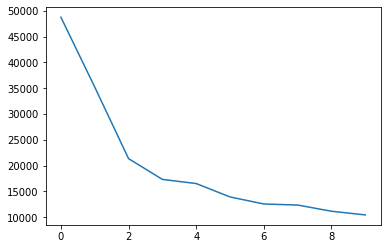

In [55]:
from collections import Counter
import matplotlib.pyplot as plt
# FREQUENCIES OF WORDS IN CORPUS
sorted_corpus_freqs_ta = sorted(Counter(corpus_ta.split(" ")).items(), key=lambda x: x[1], reverse=True)
plt.plot([(x[1]) for x in sorted_corpus_freqs_ta[:10]]), sorted_corpus_freqs_ta[:10]

([<matplotlib.lines.Line2D at 0x7f30a8f30310>],
 [('said', 76385),
  ('one', 57263),
  ('would', 46663),
  ('could', 41425),
  ('like', 36472),
  ('time', 32907),
  ('back', 32185),
  ('man', 30097),
  ('know', 28632),
  ('get', 24516)])

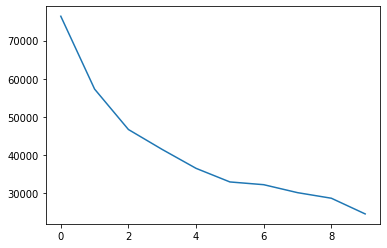

In [56]:
sorted_corpus_freqs_scifi = sorted(Counter(corpus_scifi.split(" ")).items(), key=lambda x: x[1], reverse=True)
plt.plot([(x[1]) for x in sorted_corpus_freqs_scifi[:10]]), sorted_corpus_freqs_scifi[:10]

In [57]:
# we are checking the ration of training to test sample again because we split the dataframe above, not the corpus
# in theory, we could have sampled a lot of rows from the DF with long strings and obtained a training set which is more than
# 70% of the corpus. highly unlikely given the size of the DF and the random sampling. So just to make sure we got this right.

len(corpus_ta_train) / (len(corpus_ta_train) + len(corpus_ta_test))

0.7001007930355352

In [58]:
print("n voc train: " + str(len(set(corpus_ta_train.split()))))
print("n voc test: " + str(len(set(corpus_ta_test.split()))))

print("n voc combined: " + str(len(set((corpus_ta_train + corpus_ta_test).split()))))

len(set(corpus_ta_test.split()).difference(set(corpus_ta_train.split())))

n voc train: 44016
n voc test: 28326
n voc combined: 52497


8480

In [59]:
# Vocabulary size and number of words in a sequence.
vocab_size = 10000
sequence_length = 100

# Use the text vectorization layer to normalize, split, and map strings to 
# integers. Note that the layer uses the custom standardization defined above. 
# Set maximum_sequence length as all samples are not of the same length.
"""vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=sequence_length)"""

# Make a text-only dataset (no labels) and call adapt to build the vocabulary.
#text_ds = train_ds.map(lambda x, y: x)
#vectorize_layer.adapt(text_ds)

"vectorize_layer = TextVectorization(\n    standardize=custom_standardization,\n    max_tokens=vocab_size,\n    output_mode='int',\n    output_sequence_length=sequence_length)"

### Vocabulary encoding
Encoding our vocabulary. We are encoding the full corpus, as suggested in the exercise forum.

In [60]:
vocab_ta = set(corpus_ta.split())
vocab_ta_size = len(vocab_ta)

word_to_ix = {word: i for i, word in enumerate(vocab_ta)}

In [61]:
vocab_scifi = set(corpus_scifi.split())
vocab_scifi_size = len(vocab_scifi)

word_to_ix_scifi = {word: i for i, word in enumerate(vocab_scifi)}

In [62]:
# Turning the corpus into training and test data 
CONTEXT_SIZE = 2

In [63]:
class VectorizerCBOW:
    
    def vectorize(self, context_size, corpus):
        """
        Returns:
            list of context words and the corresponding central words
        Args:
            contet_size (int): the window length to the left and to the right of the central word
            corpus (str): the cleaned corpus as on string, words seperated by space
        """
        
        # first, extract the context words and the corresponding central words
        data = []
        corpus_splt = corpus.split()
        for i in range(2, len(corpus_splt) - 2):
            context = [corpus_splt[i - 2], corpus_splt[i - 1],
                       corpus_splt[i + 1], corpus_splt[i + 2]]
            target = corpus_splt[i]
            data.append((context, target))
        
        return df

In [64]:
class VectorizerCBOW:
    
    def vectorize(self, context_size, corpus):
        """
        Returns:
            list of context words and the corresponding central words
        Args:
            contet_size (int): the window length to the left and to the right of the central word
            corpus (str): the cleaned corpus as on string, words seperated by space
        """
        
        # first, extract the context words and the corresponding central words
        data = []
        corpus_splt = corpus.split()
        for i in tqdm(range(2, len(corpus_splt) - 2)):
            context = [corpus_splt[i - 2], corpus_splt[i - 1],
                       corpus_splt[i + 1], corpus_splt[i + 2]]
            target = corpus_splt[i]
            data.append((context, target))
        
        return data
        
        
VectCBOW = VectorizerCBOW()

cont_targ_train = VectCBOW.vectorize(CONTEXT_SIZE, corpus_ta_train)


In [203]:
class NGramLanguageModeler(nn.Module):

    def __init__(self, vocab_size, embedding_dim, context_size):
        super(NGramLanguageModeler, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(context_size * embedding_dim, 128)
        self.linear2 = nn.Linear(128, vocab_size)

    def forward(self, inputs):
        embeds = self.embeddings(inputs).view((1, -1))
        out = F.relu(self.linear1(embeds))
        out = self.linear2(out)
        log_probs = F.log_softmax(out, dim=1)
        return log_probs

In [226]:
len(cont_targ_train)

1404241

Until here, everything works <br>
Below, work in progress <br>
# Hic sunt dracones

In [236]:
class CBOW(nn.Module):
    def __init__(self, vocab_size, embedding_dim, context_size):
        super(CBOW, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        #self.linear1 = nn.Linear(context_size * embedding_dim, 128)
        self.linear1 = nn.Linear(context_size * 2 * embedding_dim, 128)
        #self.linear1 = nn.Linear(200, 1)
        #print("Cont_size * emb_dim: ", context_size * embedding_dim)
        #self.linear2 = nn.Linear(128, vocab_size)
        self.linear2 = nn.Linear(128, vocab_size)
        
    def forward(self, inputs):
        #print("FORWARD CALL!")
        #print("INPUTS SHAPE: ", inputs.shape)
        #embeds = self.embeddings(inputs).view((inputs.size(0), -1))
        
        #HERE
        #embeds = self.embeddings(inputs).view((1, -1))
        
        #print("Embeds type: ", type(embeds), type(self.embeddings(inputs)))
        #print("Embeds shape / size: ", str(embeds.shape))
        #print("Embeds: ", str(embeds))
        #print(type(embeds))
        # -1 implies size inferred for that index from the size of the data
        #print(np.mean(np.mean(self.linear2.weight.data.numpy())))
        #print("First layer output shape: ", str(self.linear1(embeds)))
        #out1 = F.relu()
        
        #HERE
        #out1 = F.relu(self.linear1(embeds)) # output of first layer
        
        #print("Out1: ", str(out1))
        
        #HERE
        #out2 = self.linear2(out1)           # output of second layer
        
        #print(embeds)
        
        #HERE
        #log_probs = F.log_softmax(out2, dim=1)
        #return log_probs
        
        #return out1
        out = self.embeddings(inputs).view(1, -1)
        out = out.view(1,-1)
        out = self.linear1(out)
        out = F.relu(out)
        out = self.linear2(out)
        out = F.log_softmax(out, dim=1)
        return out
    
    def predict(self, input):
        context_idxs = torch.tensor([word_to_ix[w] for w in input], dtype=torch.long)
        res = self.forward(context_idxs)
        res_arg = torch.argmax(res)
        res_val, res_ind = res.sort(descending=True)
        res_val = res_val[0][:3]
        res_ind = res_ind[0][:3]
        #print(res_val)
        #print(res_ind)
        for arg in zip(res_val,res_ind):
            #print(arg)
            print([(key,val,arg[0]) for key,val in word_to_ix.items() if val == arg[1]])


In [ ]:
EMBED_DIM = 50
print("Context size: ", CONTEXT_SIZE)
losses = []
loss_function = nn.NLLLoss()
model = CBOW(vocab_ta_size, EMBED_DIM, CONTEXT_SIZE)
#model = NGramLanguageModeler(len(vocab_ta), EMBED_DIM, CONTEXT_SIZE)
optimizer = optim.SGD(model.parameters(), lr=0.001)

# Freeze embedding layer
#model.freeze_layer('embeddings')

for epoch in range(1):
    print(epoch)
    total_loss = 0
    #------- Embedding layers are trained as well here ----#
    #lookup_tensor = torch.tensor([word_to_ix["poor"]], dtype=torch.long)
    #hello_embed = model.embeddings(lookup_tensor)
    #print(hello_embed)
    # -----------------------------------------------------#
    i = 0
    for context, target in tqdm(cont_targ_train):
        print("Progress: {0}/{1}".format(i, len(cont_targ_train)))
        i += 1
        # Step 1. Prepare the inputs to be passed to the model (i.e, turn the words
        # into integer indices and wrap them in tensors)
        context_idxs = torch.tensor([word_to_ix[w] for w in context], dtype=torch.long)
        #print("Context id: ", context_idxs)
        #print("Context id shape: ", context_idxs.shape)

        # Step 2. Recall that torch *accumulates* gradients. Before passing in a
        # new instance, you need to zero out the gradients from the old instance
        model.zero_grad()

        # Step 3. Run the forward pass, getting log probabilities over next
        # words
        #print(model)
        log_probs = model(context_idxs)
        #print(log_probs)

        # Step 4. Compute your loss function. (Again, Torch wants the target
        # word wrapped in a tensor)
        loss = loss_function(log_probs, torch.tensor([word_to_ix[target]], dtype=torch.long))
        #print(loss)

        # Step 5. Do the backward pass and update the gradient
        loss.backward()
        optimizer.step()

        # Get the Python number from a 1-element Tensor by calling tensor.item()
        total_loss += loss.item()
    print(total_loss)
    losses.append(total_loss)
#print(losses)  # The loss decreased every iteration over the training data!

#Print the model layer parameters
#model.print_layer_parameters()

#Predict the next word given n context words
model.predict(['of','all','human'])


Context size:  2
0


Progress: 0/1404241
Progress: 1/1404241
Progress: 2/1404241
Progress: 3/1404241
Progress: 4/1404241
Progress: 5/1404241
Progress: 6/1404241
Progress: 7/1404241
Progress: 8/1404241
Progress: 9/1404241
Progress: 10/1404241
Progress: 11/1404241
Progress: 12/1404241
Progress: 13/1404241
Progress: 14/1404241
Progress: 15/1404241
Progress: 16/1404241
Progress: 17/1404241
Progress: 18/1404241
Progress: 19/1404241
Progress: 20/1404241
Progress: 21/1404241
Progress: 22/1404241
Progress: 23/1404241
Progress: 24/1404241
Progress: 25/1404241
Progress: 26/1404241
Progress: 27/1404241
Progress: 28/1404241
Progress: 29/1404241
Progress: 30/1404241
Progress: 31/1404241
Progress: 32/1404241
Progress: 33/1404241
Progress: 34/1404241
Progress: 35/1404241
